## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import csv
from IPython.display import Image, display
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

/Users/trevordoucet/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data Gathering


### Kaggle Download
Wikipedia Movie Plots: https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

In [2]:
wiki_kaggle = pd.read_csv('../data/imbd_wikipedia_movie_plots.csv')
len(wiki_kaggle)

34886

### TMDB API
The Movie Database: https://www.themoviedb.org/

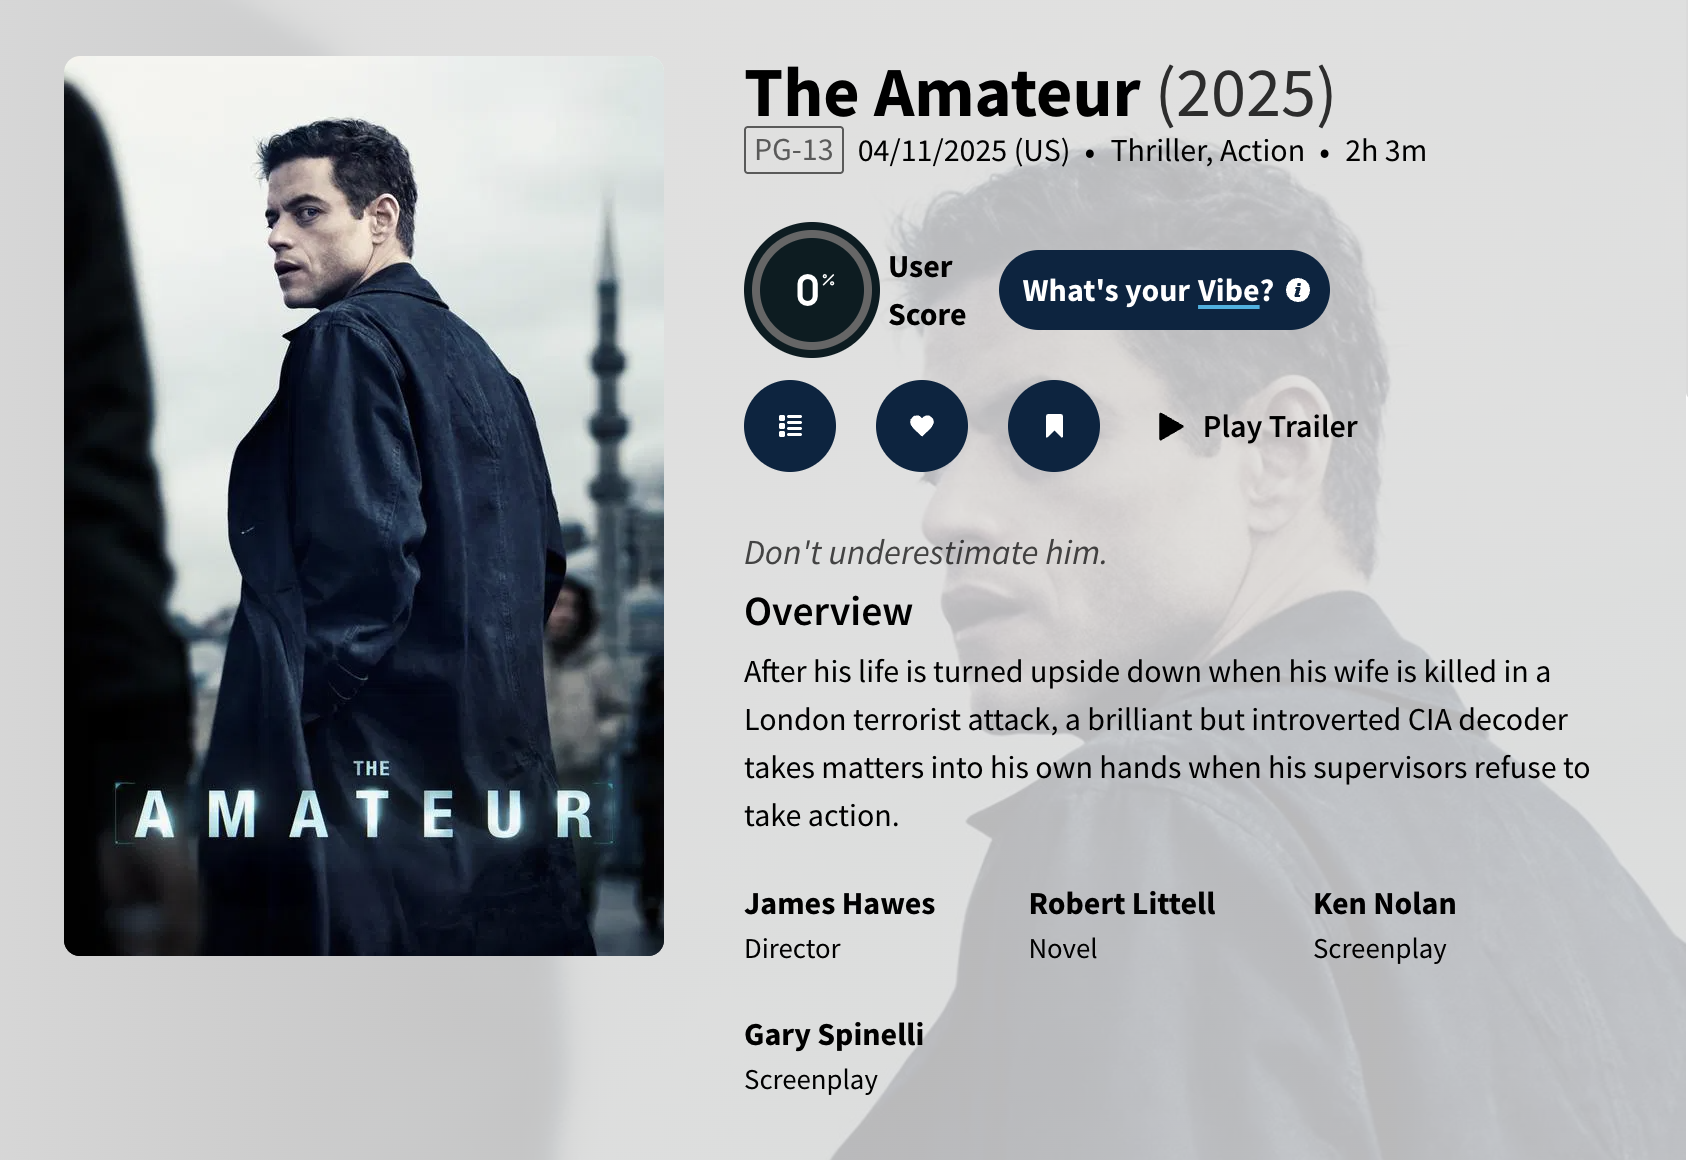

In [3]:
img = Image(filename='../imgs/tmdb_example.png', width=700, height=700)
display(img)

In [ ]:
API_KEY = '6dfc9270ab90f15631d551b42ddf4176'
BASE_URL = 'https://api.themoviedb.org/3'
OUTPUT_FILE = '../data/tmdb_movies_overviews.csv'

def fetch_movies(endpoint, page):
    url = f"{BASE_URL}/{endpoint}?api_key={API_KEY}&page={page}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

def fetch_movie_details(movie_id):
    url = f"{BASE_URL}/movie/{movie_id}?api_key={API_KEY}&language=en-US"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

def collect_movie_descriptions():
    '''
    This function was designed to grab movie details from the TMDb API endpoints (popular, top rated, and now playing)
    The purpose is to iterate through paginated results and fetch movie results
    We avoid duplicates by using set() and finally save the output to be processed

    '''
    # TMDB Categoy options
    endpoints = ['movie/popular', 'movie/top_rated', 'movie/now_playing']
    collected_ids = set() 
    
    with open(OUTPUT_FILE, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["movie_id", "title", "overview"]) 
        
        for endpoint in endpoints:
            page = 1
            while True:
                print(f"Fetching {endpoint} page {page}")
                data = fetch_movies(endpoint, page)
                if not data:
                    break
                for movie in data.get('results', []):
                    movie_id = movie.get('id')
                    if movie_id in collected_ids:
                        continue 
                    collected_ids.add(movie_id)
                    
                    details = fetch_movie_details(movie_id)
                    if details:
                        writer.writerow([
                            details.get('id'),
                            details.get('title'),
                            details.get('overview')
                        ])
                    # Helpful for avoiding rate limits
                    time.sleep(0.25)
                
                if page >= data.get('total_pages', 0):
                    break
                page += 1


collect_movie_descriptions()
print(f"Movie descriptions collected into file: '{OUTPUT_FILE}'.")

## Discovery

In [4]:
tmdb = pd.read_csv('../data/tmdb_movies_overviews.csv')
print(len(tmdb))

16913


Distribution Overview

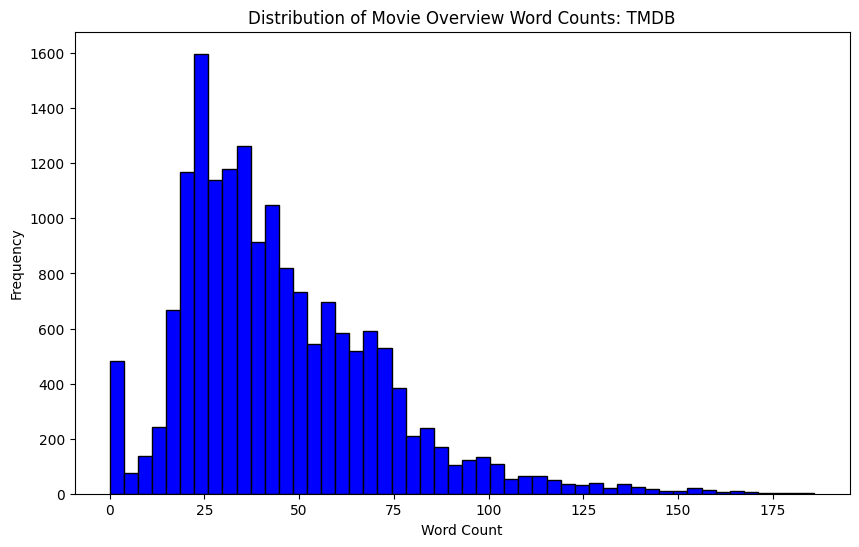

In [5]:
tmdb['word_count'] = tmdb['overview'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
plt.hist(tmdb['word_count'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Movie Overview Word Counts: TMDB')
plt.xlabel('Word Count')
plt.ylabel("Frequency")
plt.show()

In [6]:
tmdb['word_count'].describe()

count    16913.000000
mean        44.796074
std         26.132352
min          0.000000
25%         26.000000
50%         39.000000
75%         59.000000
max        186.000000
Name: word_count, dtype: float64

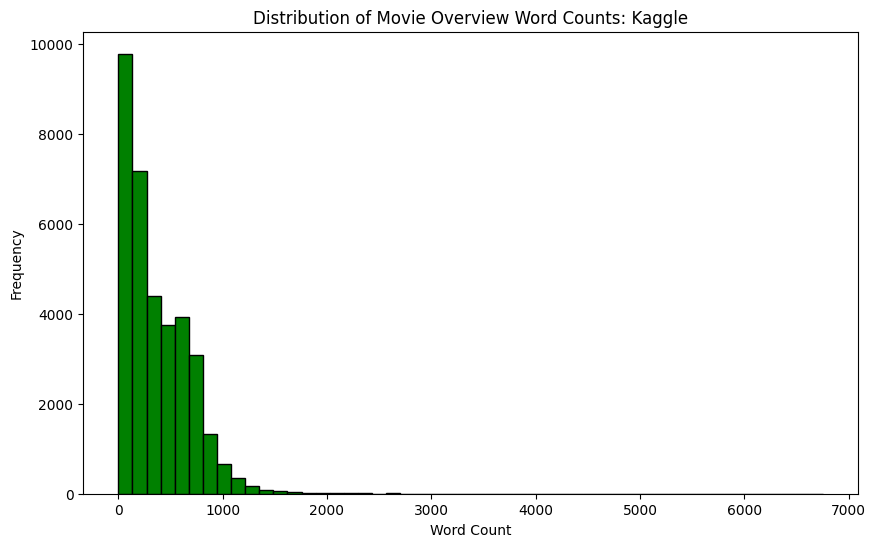

In [7]:
wiki_kaggle['word_count'] = wiki_kaggle['Plot'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

plt.figure(figsize=(10, 6))
plt.hist(wiki_kaggle['word_count'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Movie Overview Word Counts: Kaggle')
plt.xlabel('Word Count')
plt.ylabel("Frequency")
plt.show()

In [8]:
wiki_kaggle['word_count'].describe()

count    34886.000000
mean       372.493206
std        315.753223
min          2.000000
25%        122.000000
50%        284.000000
75%        581.000000
max       6752.000000
Name: word_count, dtype: float64

Word Cloud Visualization

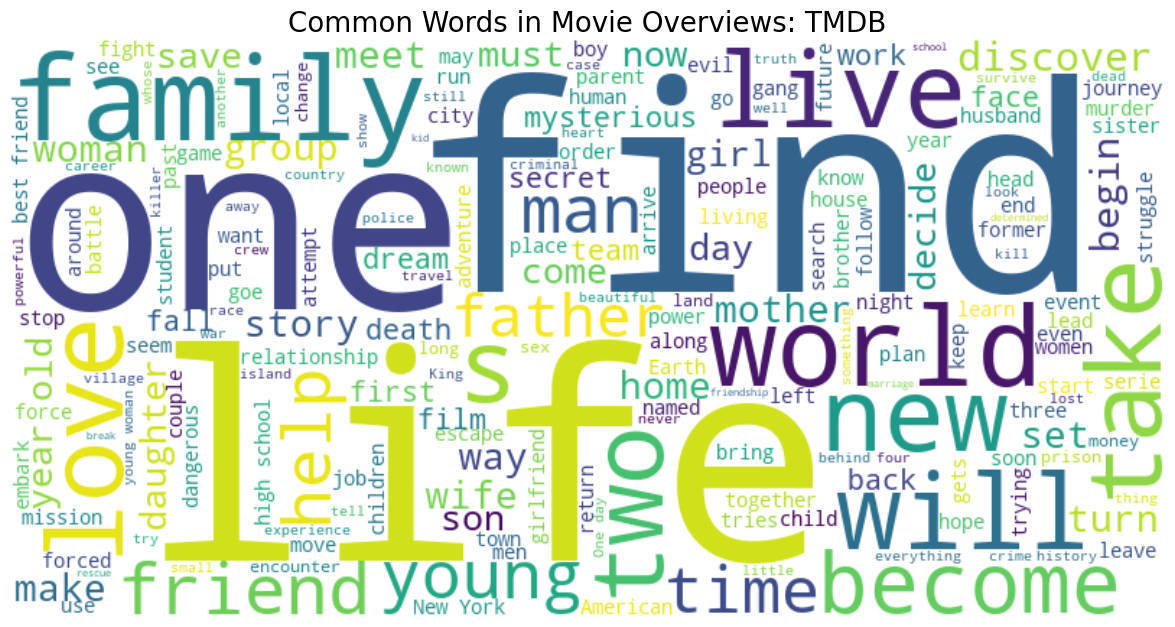

In [9]:
text = " ".join(tmdb['overview'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Movie Overviews: TMDB", fontsize=20)
plt.show()

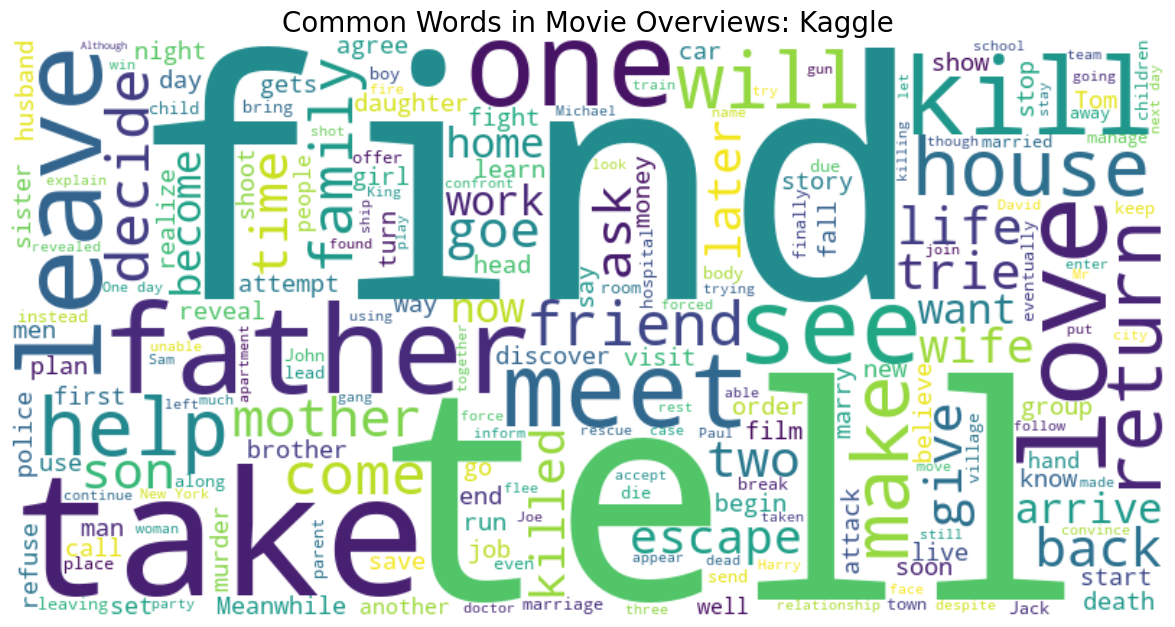

In [10]:
text = " ".join(wiki_kaggle['Plot'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Movie Overviews: Kaggle", fontsize=20)
plt.show()

N-gram Frequency Analysis

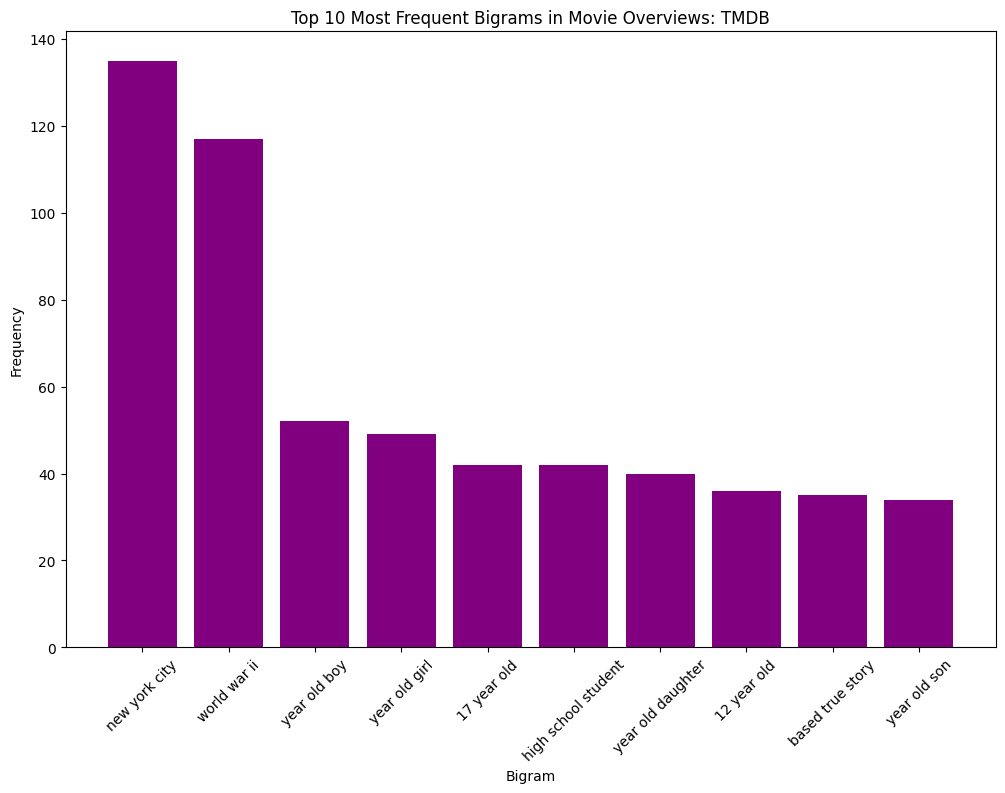

In [11]:
# Trigram
vect = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X = vect.fit_transform(tmdb['overview'].dropna())
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

words, counts = zip(*words_freq)
plt.figure(figsize=(12,8))
plt.bar(words, counts, color='purple')
plt.title('Top 10 Most Frequent Bigrams in Movie Overviews: TMDB')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

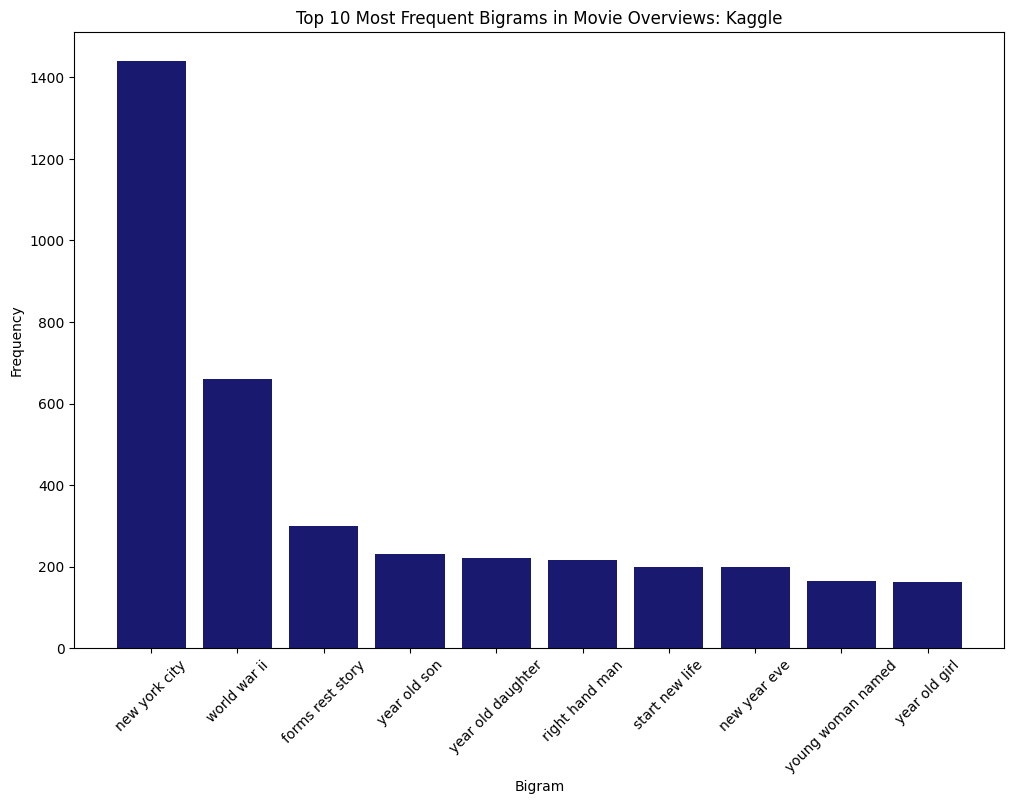

In [12]:
# Trigram
vect = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X = vect.fit_transform(wiki_kaggle['Plot'].dropna())
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

words, counts = zip(*words_freq)
plt.figure(figsize=(12,8))
plt.bar(words, counts, color='midnightblue')
plt.title('Top 10 Most Frequent Bigrams in Movie Overviews: Kaggle')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/trevordoucet/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


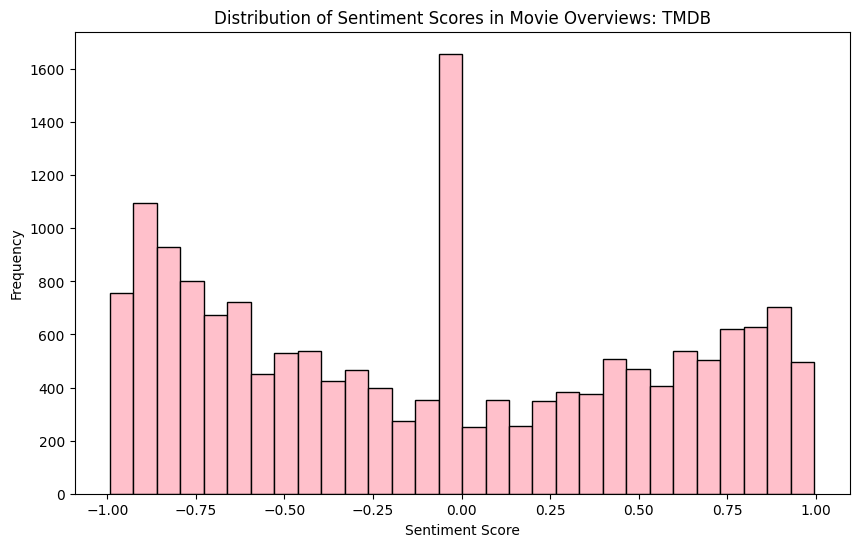

In [13]:
# Vader lexicon
nltk.download('vader_lexicon')

# Initilize analyzer
sia = SentimentIntensityAnalyzer()

tmdb['sentiment'] = tmdb['overview'].apply(
    lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0
)

plt.figure(figsize=(10, 6))
plt.hist(tmdb['sentiment'], bins=30, color='pink', edgecolor='black')
plt.title('Distribution of Sentiment Scores in Movie Overviews: TMDB')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

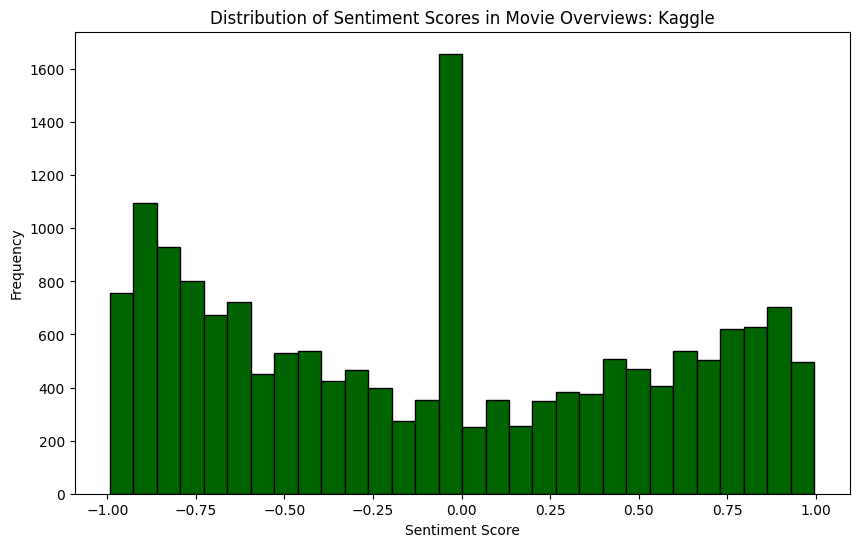

In [14]:
wiki_kaggle['sentiment'] = wiki_kaggle['Plot'].apply(
    lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else 0
)

plt.figure(figsize=(10, 6))
plt.hist(tmdb['sentiment'], bins=30, color='darkgreen', edgecolor='black')
plt.title('Distribution of Sentiment Scores in Movie Overviews: Kaggle')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## Merge Datasets

In [59]:
tmdb.head(2)

,movie_id,title,overview
0,1125899,Cleaner,When a group of radical activists take over an...
1,1229730,Carjackers,"By day, they're invisible—valets, hostesses, a..."


In [60]:
wiki_kaggle.head(2)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."


Renaming columns

In [61]:
tmdb = tmdb[['title', 'overview']]
wiki_kaggle = wiki_kaggle[['Title', 'Plot']].rename(columns={'Title': 'title', 'Plot': 'overview'})

Concat and drop duplicate titles

In [62]:
combined_descriptions = pd.concat([tmdb, wiki_kaggle]).drop_duplicates(subset=['title'])
len(combined_descriptions)

42797

# Trimming

In [63]:
combined_descriptions['word_count'] = combined_descriptions['overview'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
combined_descriptions['word_count'].describe()

count    42797.000000
mean       214.330981
std        268.895282
min          0.000000
25%         41.000000
50%         95.000000
75%        296.000000
max       6752.000000
Name: word_count, dtype: float64

In [64]:
canidate_descriptions = combined_descriptions[(combined_descriptions['word_count'] > 20) & (combined_descriptions['word_count'] < 1000)]
canidate_descriptions.word_count.describe()

count    39450.000000
mean       207.653460
std        221.042507
min         21.000000
25%         48.000000
50%        105.000000
75%        300.000000
max        999.000000
Name: word_count, dtype: float64

## Baseline Descriptions

The objective is to defined and implement baseline methods to generate two-sentence descriptions from the cleaned data.

In [67]:
nltk.download('punkt_tab', download_dir='/Users/trevordoucet/nltk_data')

def two_sentences(text):
    '''
    Tokenizes the input text into setences and returns the first two
    '''
    sentences = nltk.tokenize.sent_tokenize(text)
    if len(sentences) >= 2:
        return " ".join(sentences[:2])
    else:
        return text

canidate_descriptions['two_sentence_summary'] = canidate_descriptions['overview'].apply(two_sentences)

# Examine
canidate_descriptions[['overview', 'two_sentence_summary']].sample(10).to_excel('../data/two_sentence_summary.xlsx')
canidate_descriptions.to_excel('../data/final_descriptions.xlsx')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/trevordoucet/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/var/folders/c9/nckl2xts1ys2_knbj2y1562h0000gn/T/ipykernel_4785/1771588518.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canidate_descriptions['two_sentence_summary'] = canidate_descriptions['overview'].apply(two_sentences)
